# Лабораторная работа №6
# Ансамбли моделей машинного обучения

### Цель лабораторной работы
Изучение ансамблей моделей машинного обучения.

### Задание
- Выберите набор данных (датасет) для решения задачи классификации или регресии.
- В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
- С использованием метода train_test_split разделите выборку на обучающую и тестовую.
- Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

# Ход выполнения лабораторной работы

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
sns.set(style="ticks")

In [2]:
data = pd.read_csv('pulsar_stars.csv')

In [3]:
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
data.isnull().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

Таким образом, пропуски данных отсутствуют.

#### В качестве метрик для решения задачи классификации будем использовать:
- Precision - доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.
- Recall - доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов.

Разработаем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества.

In [5]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()   

Для задачи классификации будем использовать случайный лес и градиентный бустинг.

### Формирование обучающей и тестовой выборок

In [6]:
data.columns

Index([' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve',
       'target_class'],
      dtype='object')

In [7]:
data.dtypes

 Mean of the integrated profile                  float64
 Standard deviation of the integrated profile    float64
 Excess kurtosis of the integrated profile       float64
 Skewness of the integrated profile              float64
 Mean of the DM-SNR curve                        float64
 Standard deviation of the DM-SNR curve          float64
 Excess kurtosis of the DM-SNR curve             float64
 Skewness of the DM-SNR curve                    float64
target_class                                       int64
dtype: object

In [8]:
# Признаки для задачи классификации
class_cols = [' Mean of the integrated profile',
             ' Standard deviation of the integrated profile',
             ' Excess kurtosis of the integrated profile',
             ' Skewness of the integrated profile',
             ' Mean of the DM-SNR curve',
             ' Standard deviation of the DM-SNR curve',
             ' Excess kurtosis of the DM-SNR curve']

In [9]:
X = data[class_cols]
Y = data['target_class']
X.shape

(17898, 7)

In [10]:
# С использованием метода train_test_split разделим выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [11]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((13423, 7), (4475, 7), (13423,), (4475,))

### Обучение моделей

In [12]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [13]:
def train_model(model_name, model, MetricLogger):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    precision = precision_score(Y_test.values, Y_pred)
    recall = recall_score(Y_test.values, Y_pred)
    
    MetricLogger.add('precision', model_name, precision)
    MetricLogger.add('recall', model_name, recall)

    print('*****************************************************')
    print(model_name)
    print(model)
    print("precision_score:", precision)
    print("recall:", recall)
    print('*****************************************************')

In [14]:
train_model('Случайный лес', RandomForestClassifier(), clasMetricLogger)
train_model('Градиентный бустинг', GradientBoostingClassifier(), clasMetricLogger)

*****************************************************
Случайный лес
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
precision_score: 0.9272237196765498
recall: 0.8514851485148515
*****************************************************
*****************************************************
Градиентный бустинг
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features

### Оценка качества моделей

In [15]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall'], dtype=object)

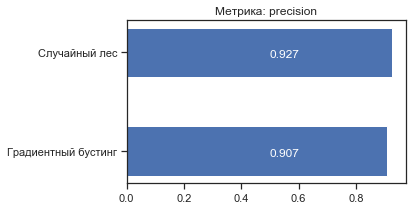

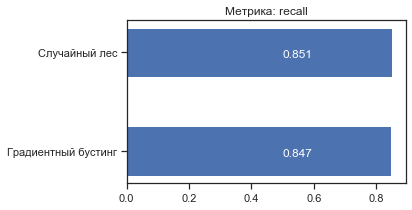

In [16]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(5, 3))

Таким образом, на основании обеих метрик лучшей моделью оказался случайный лес.